# RL coursework, part I (20 pts total)
---

**Name:** Benoît Coutière

**SN:**

---

**Due date:** *April 10th, 2025*

---
Standard UCL policy (including grade deductions) automatically applies for any late submissions.


## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import Seaborn
import collections #ADDED BY ME


np.set_printoptions(precision=3, suppress=1)
sns.set_theme(style="white")

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):

  """
  Upper Confidence Bound (UCB) algorithm for multi-armed bandit problems.

  Attributes:
      name (str): The name of the UCB instance.
      number_of_arms (int): The number of arms (actions) in the bandit problem.
      bonus_multiplier (float): The multiplier for the exploration bonus.
  """

  def __init__(self, name, number_of_arms, bonus_multiplier):

    """
    Initialize the UCB algorithm.

    Args:
        name (str): The name of the UCB instance.
        number_of_arms (int): The number of arms (actions) in the bandit problem.
        bonus_multiplier (float): The multiplier for the exploration bonus.
    """
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):

    """
    Perform a step in the UCB algorithm.

    Args:
        previous_action (int or None): The previous action taken. None if no action was taken.
        reward (float): The reward received from the previous action.

    Returns:
        int: The next action to take.
    """

    if previous_action is not None:
      # Update the count and value estimate for the previous action
      self.counts[previous_action] += 1
      self.total_steps += 1
      value = self.values[previous_action]
      new_value = value + (reward - value) / self.counts[previous_action]
      self.values[previous_action] = new_value

      # Calculate the next action using the UCB formula
      action = np.argmax(self.values + self._bonus_multiplier * np.sqrt(np.log(max(1, self.total_steps))/(self.counts + 1e-5)))
    else :
      # If no previous action, select a random action
      action = np.random.randint(self._number_of_arms)

    return action

  def reset(self):
    """
    Reset the counts and value estimates for all arms.
    """
    self.counts = np.zeros(self._number_of_arms)
    self.values = np.zeros(self._number_of_arms)
    self.total_steps = 0

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """
  An epsilon-greedy agent for multi-armed bandit problems.

  This agent selects an action between 0 and 'number_of_arms'. With probability
  `(1-epsilon)`, it chooses the action with the highest estimated value, while
  with probability `epsilon`, it samples an action uniformly at random.

  Attributes:
      name (str): The name of the EpsilonGreedy instance.
      number_of_arms (int): The number of arms (actions) in the bandit problem.
      epsilon (float or callable): The probability of choosing a random action.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    """
    Initialize the EpsilonGreedy agent.

    Args:
        name (str): The name of the EpsilonGreedy instance.
        number_of_arms (int): The number of arms (actions) in the bandit problem.
        epsilon (float or callable, optional): The probability of choosing a random action.
                                                   Can be a function of the total steps. Defaults to 0.1.
    """
    self._number_of_arms = number_of_arms
    self.eps=epsilon
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    """
    Update the learned statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.

    Args:
        previous_action (int or None): The previous action taken. None if no action was taken.
        reward (float): The reward received from the previous action.

    Returns:
        int: The next action to take.
    """

    if previous_action is None:
      # If no previous action, select a random action
      action = np.random.randint(self._number_of_arms)

    else :
      # Increment the total number of steps taken
      self.total_steps += 1

      # Update the count and value estimate for the previous action
      self.counts[previous_action] += 1

      value = self.values[previous_action]
      new_value = value + (reward - value) / self.counts[previous_action]
      self.values[previous_action] = new_value

      # Determine the current epsilon value
      epsilon_value = self.eps(self.total_steps) if callable(self.eps) else self.eps

      # Choose the next action based on epsilon-greedy policy
      if np.random.random() < epsilon_value:
        action = np.random.randint(self._number_of_arms)
      else:
        max_value = np.max(self.values)
        max_indices = np.where(self.values == max_value)[0]
        action = np.random.choice(max_indices)

    return action

  def reset(self):
    """
    Reset the counts and value estimates for all arms.
    """
    self.counts = np.zeros(self._number_of_arms)
    self.values = np.zeros(self._number_of_arms)
    self.total_steps = 0

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
import numpy as np

class REINFORCE(object):
    """
    REINFORCE algorithm implementation.

    Attributes:
        name (str): Agent identifier
        number_of_arms (int): Number of possible actions
        step_size (float): Learning rate parameter
        baseline (bool): Baseline usage flag
        preferences (ndarray): Action preference values
        counts (ndarray): Per-action selection counts
        baseline_values (float): Running reward baseline
        pi (ndarray): Current policy probabilities
    """
    def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
        """
        Initialize REINFORCE agent.

        Args:
            name (str): Agent identifier
            number_of_arms (int): Number of possible actions
            step_size (float): Learning rate (default: 0.1)
            baseline (bool): Use baseline subtraction (default: False)
        """
        self.name = name
        self.number_of_arms = number_of_arms
        self.step_size = step_size
        self.baseline = baseline
        self.reset()

    def step(self, previous_action, reward):
        """
        Execute one algorithm iteration.

        Args:
            previous_action (int/None): Last taken action (None for first step)
            reward (float): Observed reward

        Returns:
            int: Next action selection
        """
        # Initial random action selection
        if previous_action is None:
            return np.random.randint(self.number_of_arms)

        # Update counter
        self.counts[previous_action] += 1

        # Calculate baseline
        total_steps = np.sum(self.counts)
        current_baseline = self.baseline_values if self.baseline else 0

        if total_steps > 0:
            self.baseline_values += (1/total_steps) * (reward - self.baseline_values)

        # Numerical stability parameters
        epsilon = 1e-8
        sum_squared_prefs = np.sum(self.preferences**2) + epsilon

        # Compute policy gradient components
        gradient = np.zeros_like(self.preferences)

        # Gradient for selected action
        gradient[previous_action] = 2/(self.preferences[previous_action] + epsilon)

        # Gradient for all actions
        gradient -= 2 * self.preferences / sum_squared_prefs

        # Update preferences
        self.preferences += self.step_size * (reward - current_baseline) * gradient

        # Calculate new policy probabilities
        self.pi = np.square(self.preferences) / sum_squared_prefs
        self.pi /= np.sum(self.pi)

        # Select next action using current policy
        return np.random.choice(self.number_of_arms, p=self.pi)

    def reset(self):
        """
        Reset agent to initial state.
        """
        self.preferences = np.ones(self.number_of_arms)
        self.counts = np.zeros(self.number_of_arms)
        self.baseline_values = 0
        self.pi = np.ones(self.number_of_arms)/self.number_of_arms

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1
from functools import partial

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

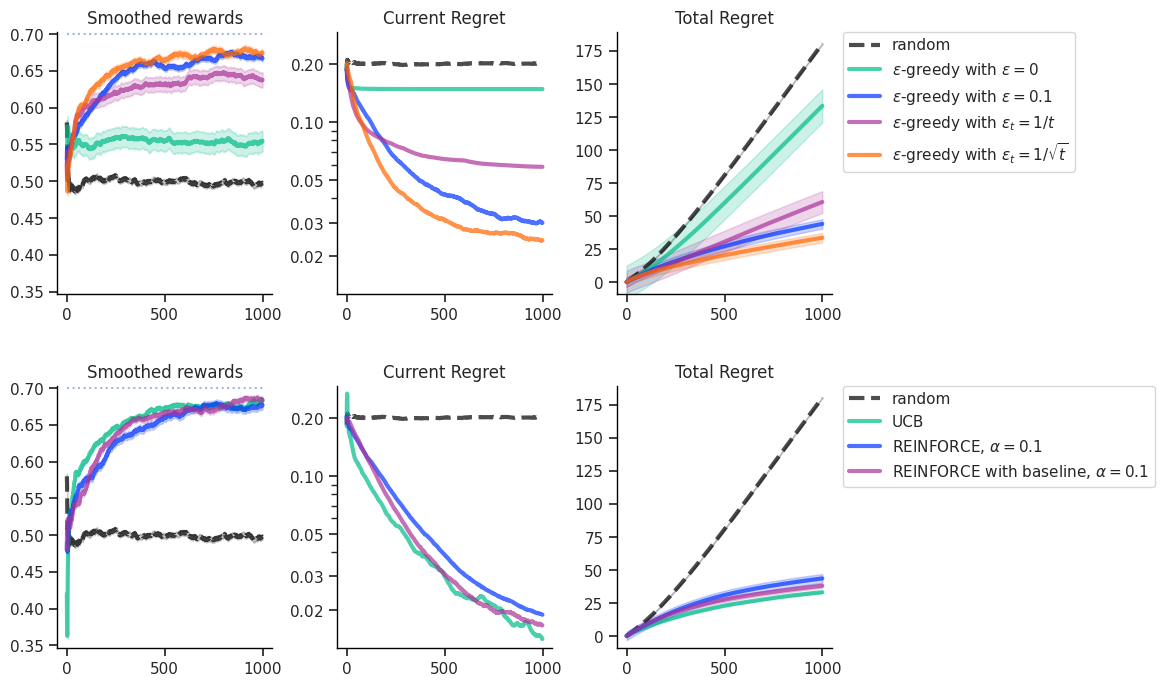

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

- **ϵ-greedy algorithm** : The epsilon-greedy algorithm’s performance hinges on how its exploration rate (ε) is managed. When ε is fixed, the algorithm exhibits linear total regret over time because it never stops exploring suboptimal actions at a constant rate. This perpetual exploration prevents it from fully committing to the optimal action, leading to regret that grows linearly with the number of steps. However, if ε is adaptively decayed over time (for instance with εₜ = $\frac{1}{𝑡}$) the algorithm transitions from exploration to exploitation as confidence in action-value estimates grows. With such a decaying ε, the total regret becomes logarithmic, aligning it with asymptotically optimal algorithms. Thus, while the "vanilla" fixed-ε version is suboptimal, a well-designed decaying ε schedule makes epsilon-greedy competitive for regret minimization.

- **REINFORCE algorithm** : REINFORCE is a policy gradient method that directly optimizes a stochastic policy by ascending the gradient of expected reward. It increases the probability of actions that yield high rewards and decreases others, which should lead to convergence toward the optimal policy. However, its performance regarding total regret is heavily dependent on its learning rate. A constant learning rate often results in linear or sublinear-but-suboptimal regret due to high variance in gradient estimates, which destabilizes learning. This algorithmis good in terms of total regret, but its sensitivity to tuning and lack of robust exploration-exploitation balancing could make it less reliable for regret minimization compared to UCB.

- **UCB** : The UCB algorithm achieves logarithmic total regret. It balances exploration and exploitation by selecting actions with the highest upper confidence bound—a metric that combines the empirical average reward of an action with an uncertainty term. This "optimism under uncertainty" principle ensures that under-explored actions with high potential are prioritized early, while exploitation dominates once confidence intervals shrink. UBC requires no hyperparameter tuning to guarantee logarithmic regret, making it robust and theoretically principled. Therefore, this algorithm should be expected to be very good in terms of total regret.


**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

- **ϵ-greedy algorithm for ϵ = 0** : As expected, this algorithm has the highest total regret. This is explained by the fact that ϵ=0 implies that this algorithm won't explore other actions than the one it's already doing : this vanilla ϵ-greedy algorithm probably got stuck in a suboptimal action at the beginning of the training and therefore has a persistent regret over time.

- **ϵ-greedy algorithm for ϵ = $\frac{1}{t}$** : While adaptive (decaying
ϵ), the exploration rate $\frac{1}{t}$ decreases too rapidly. Early exploration is insufficient to reliably identify the optimal action, causing the algorithm to "lock in" to a suboptimal choice as ϵ approaches zero. This resembles the ϵ = 0 case but with slightly better initial exploration.

- **ϵ-greedy algorithm for ϵ = 0.1** : This algorithm has the $3^{rd}$ highest total regret, which is explained by the fact that it persistently explores one time out of ten a new action: this rate is sufficient to find the best action to do, but is suboptimal as it will continue to pick new actions one time out of ten even after identifying the optimal action.

- **ϵ-greedy algorithm for ϵ = $\frac{1}{\sqrt{t}}$** : This algorithm has the lowest total regret, which is explained by the fact that it's exploration rate ($\frac{1}{\sqrt{t}}$) decreases sufficiently slowly to find the best action, but sufficiently rapidly to avoid picking too often random actions when it has found the optimal one.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

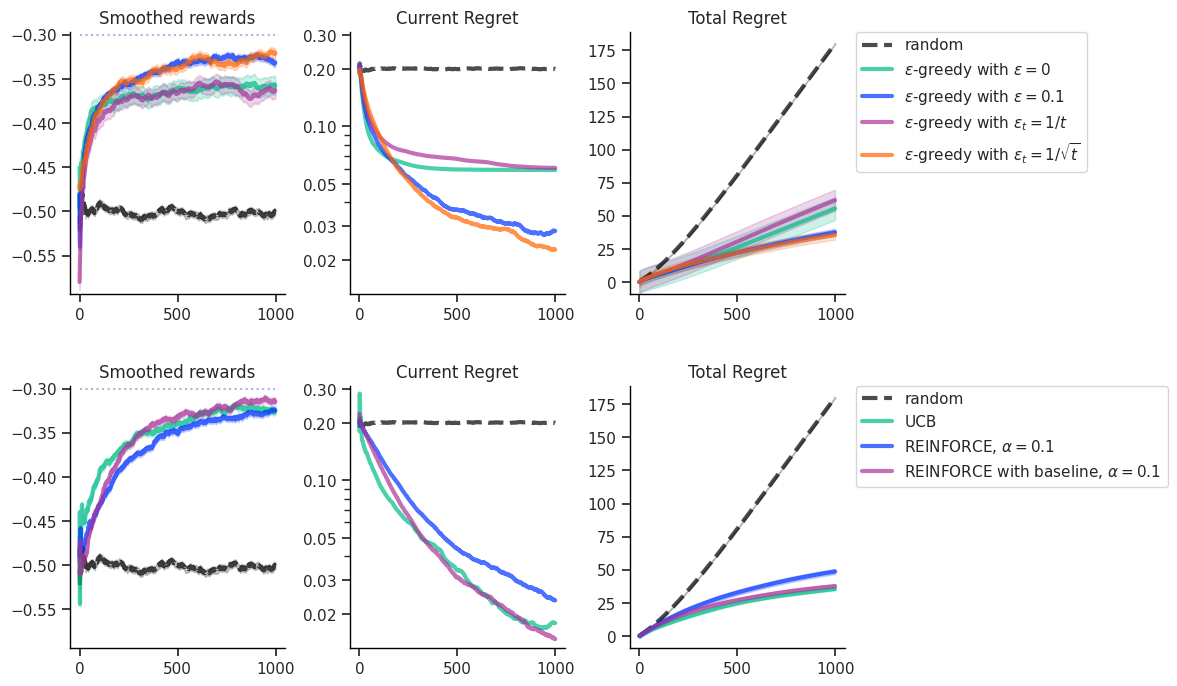

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

- **ϵ-greedy algorithm for ϵ = 0** : The total regret of this algorithm decreased a lot, which can be exlpained by the fact that the change of reward structure guided the algorithm to select better greedy actions. Since the reward for failure is -1, the updated value for an action leading to failure will be negative. Therefore the greedy algorithm will avoid selecting those acitons, and will prefer to explore new ones (since unexplored actions and success have a reward of 0). Theredore, in this configuration, the greedy algorithm will explore better than in the previous one.
- **ϵ-greedy algorithm for ϵ = $\frac{1}{t}$** : The total regret of this algorithm decreased a little bit, which can be eexplained by the same argument as the one advanced for the fully greedy algorithm.
- **ϵ-greedy algorithm for ϵ = 0.1** : The total regret of this algorithm didn't change, which is due to the fact that it managed before and still manages to select the optimal action independently from the value of the reward, but suffers from the fact that the random exploration harms its total regret over time.
- **ϵ-greedy algorithm for ϵ = $\frac{1}{\sqrt{t}}$** : The total regret of this algorithm didn't change, which is due to the fact that it managed before and still manages to select the optimal action independently from the value of the reward, by smoothly adapting its exploration rate throgh time to balance exploration and exploitation.
- **REINFORCE algorithm without baseline** :
The total regret of this algorithm seems to have increased a little bit. This coud be explained by the fact that REINFORCE now learns how to punish failure and not how to reward success (when we select a successful action, its gradient remains 0). Therefore, the algorithm only learns from its failures and learns slower.
- **REINFORCE algorithm with baseline** :
The total regret of this algorithm seems to have remained identical. This could be explained by the fact that the baseline allows the gradient applied to failure and success to be non null : whatever action is taken, the algorithm learns from it.
- **UCB ** : The total regret of this algorithm didn't change, which is due to the fact that it managed before and still manages to select the optimal action independently from the value of the reward.

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

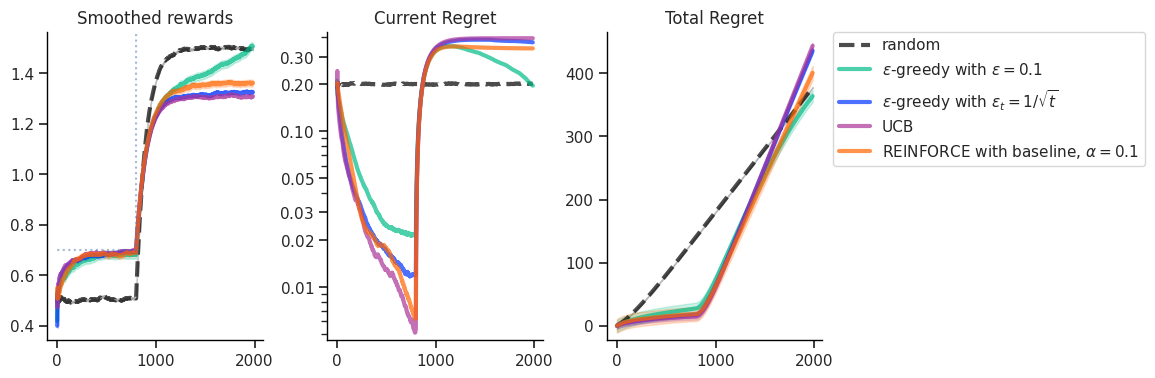

In [15]:
experiment3.show()

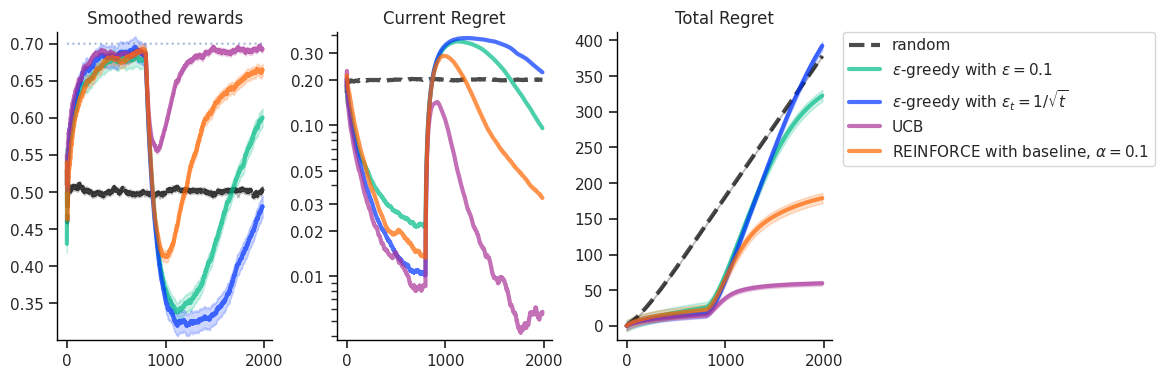

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

After 800 steps, what was previsously a success becomes a failure, and what was previously a failure becomes a success.

- **UCB** : has the higher current regret, which is explained by the fact that this algorithm learned to select the action that was initially a success, and continues to do so after the $800^{th}$ step. The previously successful action has a high exploitation term, and a very low exploration term, so it will take time for the algorithm to gather enough samples to overcome this high confidence in the previously optimal action and to select the new optimal action.

- **ϵ-greedy algorithm (ϵ=$\frac{1}{\sqrt{t}}$)** : has the second higher current regret, which is explained by the fact that by the $800^{th}$ step, its exploration rate is ϵ is equal to 0.035 : this algorithm will mostly select the action that was initially a success, which keeps its regret high as this action became a failure after this step. Nevertheless, this algorithm will rarely select the action that is a new success, which explains why its current regret is inferior to UCB.

- **REINFORCE with baseline** : has the third higher current regret. Around the $800^th$ step, this algorithm only selects the reward. Therefore, the fact that the value of the reward remains the same implies that the gradient of the successful action will remain the same (close to 0), and that REINFORCE will not be able to explore and discover the new successful action.

- **ϵ-greedy algorithm (ϵ=0.1)** : has the fourth higher current regret. This algorithm learned to select the action that was previously a reward, which explains why its regret increased after the change. But its constant exploration rate of 0.1 allows this algorithm to adapt and explore the new environment faster than the other algorithms, by selecting the new successful action more often.


**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

- **ϵ-greedy algorithm (ϵ=$\frac{1}{\sqrt{t}}$)** : has the higher current regret, which is explained by the fact that by the $800^{th}$ step, its exploration rate is ϵ is equal to 0.035 : this algorithm will mostly select the action that was initially a success, which keeps its regret high as this action became a failure after this step.

- **ϵ-greedy algorithm (ϵ=$\frac{1}{\sqrt{t}}$)** : has the second higher current regret. This algorithm learned to select the action that was previously a reward, which explains why its regret increased after the change.  But its constant exploration rate of 0.1 allows this algorithm to adapt and explore the new environment faster than the other ϵ-greedy algorithm, by selecting the new successful action more often.

- **REINFORCE with baseline** : has the third higher current regret. The fact that this algorithm learns directly the policy through gradient ascent allows it to change faster after the $800^{th}$ step as it is not "blocked" towards selecting the previously successful action : since the rewards change for both vaulure and success, the gradients are non null and the algorithm can learn the new policy.

- **UCB** : has the fourth higher current regret. After the 800th step, the estimated reward of the old successful action decreases over time, lowering its upper confidence bound. Meanwhile, the new optimal action has a high uncertainty term due to fewer trials, which increases its UCB score. This dynamic encourages UCB to explore the new optimal action more frequently. Over time, the algorithm shifts its focus to the new optimal action, as its UCB score surpasses that of the old action.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

In both experiments, the behavior of UCB is exactly the same before the $800^{th}$ step.

In Experiment 3, the reward for the previously successful action remains +1, while the previously failing action now yields +2. Despite this change, UCB continues to heavily exploit the previously successful action because its estimated reward remains high, and its upper confidence bound (UCB score) stays elevated due to its low uncertainty (from many prior trials). The new optimal action (+2) will not be explored and its UCB score will therefore remain the same (as UCB is focused on the previously successful action and continues to select it) which explains why the current regret for UCB in experiment 3 stays high.

In Experiment 4, the reward for the previously successful action drops from +1 to 0, while the previously failing action now yields +1. Here, the estimated reward of the old action decreases over time, lowering its UCB score. Meanwhile, the new optimal action gains a higher exploration term due to its uncertainty and an increasing exploitation term as it is sampled more often. This encourages UCB to select the new optimal action more frequently. The transition occurs between steps 800 and 1500, where regret initially increases (as UCB continues to select the now suboptimal action) but then decreases as UCB shifts its focus to the new optimal action. By step 1800, UCB fully adapts, selecting only the new optimal action, and regret stabilizes at a lower level.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.


If rewards can be non stationary and we don't know the nature of the non stationarity, we can help UCB adapt faster by applying an adaptative factor to the new obsercvations. Therefore, the new observations would be more heavily taken into consideration than the previous ones. Here would be a corrected formula for UCB :

$
\text{UCB}_t(a) = \frac{\sum_{s=1}^{t} \gamma^{t-s} \cdot r_s(a) \cdot \mathbb{I}\{a_s = a\}}{\sum_{s=1}^{t} \gamma^{t-s} \cdot \mathbb{I}\{a_s = a\}} + c \cdot \sqrt{\frac{\ln t}{\sum_{s=1}^{t} \gamma^{t-s} \cdot \mathbb{I}\{a_s = a\}}}
$